<a href="https://colab.research.google.com/github/ywsyws/RecommendationSystemExercise/blob/main/olist_NCF_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library and Data

In [1]:
!pip install pytorch_lightning

     |████████████████████████████████| 1.0 MB 5.3 MB/s 
     |████████████████████████████████| 329 kB 46.8 MB/s 
     |████████████████████████████████| 829 kB 37.5 MB/s 
     |████████████████████████████████| 132 kB 46.9 MB/s 
     |████████████████████████████████| 596 kB 41.2 MB/s 
     |████████████████████████████████| 1.1 MB 44.7 MB/s 
     |████████████████████████████████| 192 kB 44.7 MB/s 
     |████████████████████████████████| 271 kB 43.9 MB/s 
     |████████████████████████████████| 160 kB 47.1 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=4ab187ca91b02a6a99e3d5450b1963f6f0c5eb2b3c3597255b83b16f21133115
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: future
    Found exis

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import seaborn as sns
import torch
import torch.nn as nn
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from torchmetrics import RetrievalMAP, RetrievalMRR, RetrievalPrecision, RetrievalRecall
from typing import Union

np.random.seed(123)
pd.options.mode.chained_assignment = None

In [3]:
# import dataset
df = pd.read_csv('df_cleaned.csv')
df.shape

(112650, 6)

In [4]:
df.head()

,customer_id,customer_city,order_purchase_timestamp,product_id,product_weight_g,purchase
0,50044,1379,2017-05-16 15:05:35,21694,8683.0,1
1,15329,3420,2018-01-12 20:48:24,9721,10150.0,1
2,2253,3588,2018-05-19 16:07:45,24283,8267.0,1
3,14097,2336,2018-03-13 16:06:38,21209,12160.0,1
4,19599,705,2018-07-29 09:51:30,18959,5200.0,1


# Helper Functions

In [5]:
def sparsity(user_id: pd.Series, item_id: pd.Series, decimal: int):
    n_users = user_id.nunique()
    n_items = item_id.nunique()
    print(f"Number of customers: {n_users}")
    print(f"Number of products: {n_items}")
    sparsity = round(1 - len(df) / (n_users * n_items), decimal)
    print(f"The sparsity level of the original df is {sparsity*100}%")

def rank_product_count(item: pd.Series) -> pd.DataFrame:
    df = item.value_counts().reset_index()
    df.columns = [df.columns[1], "counts"]
    return df

def plot_pdt_counts(item: pd.Series, cutoff: float, xlim: int = None):
    df = rank_product_count(item)
    df["counts_ratio"] = df.counts.cumsum() / df.counts.sum()

    # plot product counts
    plt.plot(df.counts)

    # plot vertical cutoff line
    head = df[df.counts_ratio <= cutoff]
    tail = df[df.counts_ratio > cutoff]
    n_head = len(head)
    n_tail = len(tail)
    plt.axvline(x=n_head, color="r", linestyle="--")

    # fill area
    x1 = head.index.values
    y1 = head.counts
    x2 = tail.index.values
    y2 = tail.counts

    plt.fill_between(x1, y1, color="blue", alpha=0.3)
    plt.fill_between(x2, y2, color="grey", alpha=0.3)

    # set labels
    plt.title("Product Counts Plot")
    plt.ylabel("# of Purchase")
    plt.xlabel("# of Product")
    if not xlim:
        xlim = len(df)
    plt.xlim(0, xlim)

    plt.show()

# Data Analysis

In [6]:
# check sparsity
sparsity(df.customer_id, df.product_id,6)

Number of customers: 95420
Number of products: 32951
The sparsity level of the original df is 99.9964%


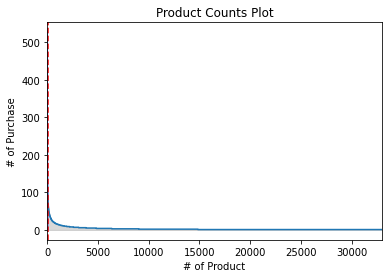

In [7]:
plot_pdt_counts(df.product_id, cutoff=0.1)

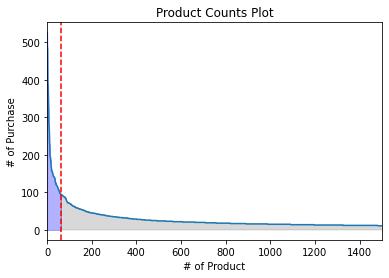

In [8]:
plot_pdt_counts(df.product_id, cutoff=0.1, xlim=1500)

# Train Test Split

In [9]:
# convert 'order_purchase_timestamp' to datetime
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])

In [10]:
def split_train_test(df: pd.DataFrame, user:str, time:str) -> Union[pd.DataFrame]:
    # leave one out
    df["rank_latest"] = df.groupby([user])[time].rank(
        method="first", ascending=False
    )
    train = df[df.rank_latest != 1]
    test = df[df.rank_latest == 1]
    
    # keep only useful columns
    train.drop(columns=[time, 'rank_latest'], inplace=True)
    test.drop(columns=[time, 'rank_latest'], inplace=True)
    
    print(f'Shape of the train set: {train.shape}')
    print(f'Shape of the test set: {test.shape}')
    
    return train, test

In [11]:
df_train, df_test = split_train_test(df, user='customer_id', time='order_purchase_timestamp')

Shape of the train set: (17230, 5)
Shape of the test set: (95420, 5)


In [12]:
print(f'Number of common users: {len(set(df_train.customer_id).intersection(df_test.customer_id))}')

Number of common users: 11869


# Define PyTorch Dataset

In [13]:
class BuildDataset(Dataset):
    """Build PyTorch Dataset for Training

    Args:
        df (pd.DataFrame): Dataframe containing the movie df
        all_item_ids (list): List containing all movieIds

    """

    def __init__(self, df: pd.DataFrame, all_item_ids):
        """
        Balance and initialize the training data and labels
        """
        (
            self.users,
            self.cities,
            self.items,
            self.weights,
            self.labels,
        ) = self.generate_neg(df, all_item_ids)

    def __len__(self):
        """
        Returns the number of samples in the training data
        """
        return len(self.users)

    def __getitem__(self, idx):
        """
        Loads and returns a sample from the dataset with the given index.
        """
        # user data
        uid = self.users[idx]
        city = self.cities[idx]

        # item data
        iid = self.items[idx]
        weight = self.weights[idx]

        sample = {
            "user_inputs": {"uid": uid, "city": city},
            "item_inputs": {"iid": iid, "weight": weight},
            "labels": self.labels[idx],
        }

        return sample

    def generate_neg(self, df, all_item_ids):
        """
        Generate 4 random negative interactions for
        every purchase (positive interaction)
        """
        # training data placeholders
        users, cities, items, weights, labels = [], [], [], [], []
        # user-item interaction set that contains items that
        # each user has interaction with
        user_item_set = set(zip(df["customer_id"], df["product_id"]))

        # 4:1 ratio of negative to positive samples
        num_neg = 4  # can be tuned
        for user, pos_item in user_item_set:
            users.append(user)
            cities.append(df["customer_city"][df["customer_id"] == user].iloc[0])
            items.append(pos_item)
            weights.append(df["product_weight_g"][df["product_id"] == pos_item].iloc[0])
            labels.append(1)  # items that the user has interacted with are positive
            for _ in range(num_neg):
                # randomly select an item
                neg_item = np.random.choice(all_item_ids)
                # check that the user has not interacted with this item
                while (user, neg_item) in user_item_set:
                    neg_item = np.random.choice(all_item_ids)
                users.append(user)
                cities.append(df["customer_city"][df["customer_id"] == user].iloc[0])
                items.append(neg_item)
                weight_neg = df["product_weight_g"][df["product_id"] == neg_item]
                if len(weight_neg) > 1:
                    weights.append(weight_neg.iloc[0])
                else:
                    weights.append(weight_neg.item())
                labels.append(0)  # items not interacted with are negative

        return (
            torch.tensor(users),
            torch.tensor(cities),
            torch.tensor(items),
            torch.tensor(weights),
            torch.tensor(labels),
        )

# Define Models

In [14]:
class TQDMProgressBar(TQDMProgressBar):
    def init_train_tqdm(self):
        bar = super().init_train_tqdm()
        bar.refresh_rate = 50
        return bar

## Simple NCF

In [15]:
class NCF_simple(pl.LightningModule):
    """Neural Collaborative Filtering (NCF)

    Args:
        n_custs (int): Number of unique users
        n_items (int): Number of unique items
        df (pd.DataFrame): Dataframe containing the movie df for training
        all_item_ids (list): List containing all movieIds (train + test)
    """

    def __init__(self, attribute_max, df, all_item_ids, embed_dim=8, fc_size=64):
        super(NCF_simple, self).__init__()

        # user embeddings
        self.embedding_uid = nn.Embedding(
            num_embeddings=attribute_max["uid"], embedding_dim=embed_dim
        )
        # item embeddings
        self.embedding_iid = nn.Embedding(
            num_embeddings=attribute_max["iid"], embedding_dim=embed_dim
        )
        
        # dense layer
        self.fc1 = nn.Linear(in_features=16, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=32)
        self.output = nn.Linear(in_features=32, out_features=1)

        # BatchNorm layer
        self.BN = nn.BatchNorm1d(64)

        self.df = df
        self.all_item_ids = all_item_ids

    def forward(self, train_user, train_item):

        # unpack train_data
        uid = train_user["uid"]
        city = train_user["city"]

        iid = train_item["iid"]
        weight = train_item["weight"]

        # Pass through embedding layers
        user_embedded = self.embedding_uid(uid)
        item_embedded = self.embedding_iid(iid)

        # Concat the two embedding layers
        x = torch.cat(
            [user_embedded, item_embedded], dim=-1
        )

        # Pass through dense layer
        x = nn.ReLU()(self.fc1(x))
        x = self.BN(x)
        x = nn.ReLU()(self.fc2(x))

        # Output layer
        pred = nn.Sigmoid()(self.output(x))

        return pred

    def training_step(self, batch, batch_idx):
        predicted_labels = self(batch["user_inputs"], batch["item_inputs"])
        loss = nn.BCELoss()(predicted_labels, batch["labels"].view(-1, 1).float())
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

    def train_dataloader(self):
        return DataLoader(
            BuildDataset(self.df, self.all_item_ids),
            batch_size=512,
            num_workers=4,
        )

## Upgrade NCF

In [16]:
class NCF(pl.LightningModule):
    """Neural Collaborative Filtering (NCF)

    Args:
        n_custs (int): Number of unique users
        n_items (int): Number of unique items
        df (pd.DataFrame): Dataframe containing the movie df for training
        all_item_ids (list): List containing all movieIds (train + test)
    """

    def __init__(self, attribute_max, df, all_item_ids, embed_dim=8, fc_size=64):
        super(NCF, self).__init__()

        # user embeddings
        self.embedding_uid = nn.Embedding(
            num_embeddings=attribute_max["uid"], embedding_dim=embed_dim
        )
        self.embedding_city = nn.Embedding(
            num_embeddings=attribute_max["city"], embedding_dim=embed_dim
        )

        # item embeddings
        self.embedding_iid = nn.Embedding(
            num_embeddings=attribute_max["iid"], embedding_dim=embed_dim
        )
        self.embedding_weight = nn.Embedding(
            num_embeddings=attribute_max["weight"], embedding_dim=embed_dim
        )
        
        # dense layer
        self.fc1 = nn.Linear(in_features=32, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=32)
        self.output = nn.Linear(in_features=32, out_features=1)

        # BatchNorm layer
        self.BN = nn.BatchNorm1d(64)

        self.df = df
        self.all_item_ids = all_item_ids

    def forward(self, train_user, train_item):

        # unpack train_data
        uid = train_user["uid"]
        city = train_user["city"]

        iid = train_item["iid"]
        weight = train_item["weight"]

        # Pass through embedding layers
        user_embedded = self.embedding_uid(uid)
        city_embedded = self.embedding_city(city)
        item_embedded = self.embedding_iid(iid)
        weight_embedded = self.embedding_weight(weight.detach().clone().long())

        # Concat the two embedding layers
        x = torch.cat(
            [user_embedded, city_embedded, item_embedded, weight_embedded], dim=-1
        )

        # Pass through dense layer
        x = nn.ReLU()(self.fc1(x))
        x = self.BN(x)
        x = nn.ReLU()(self.fc2(x))

        # Output layer
        pred = nn.Sigmoid()(self.output(x))

        return pred

    def training_step(self, batch, batch_idx):
        predicted_labels = self(batch["user_inputs"], batch["item_inputs"])
        loss = nn.BCELoss()(predicted_labels, batch["labels"].view(-1, 1).float())
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

    def train_dataloader(self):
        return DataLoader(
            BuildDataset(self.df, self.all_item_ids),
            batch_size=512,
            num_workers=4,
        )

# Run and Inference Models

In [17]:
# initialize metrics
MAP = RetrievalMAP()
MRR = RetrievalMRR()
precision = RetrievalPrecision(k=10)
recall = RetrievalRecall(k=10)

## Simple NCF

In [18]:
%%time
attribute_max={
    'uid': df.customer_id.max() + 1,
    'city': df.customer_city.max() + 1,
    'iid': df.product_id.max() + 1,
    'weight': int(df.product_weight_g.max()) + 1,
}

# Get a list of all item IDs
all_item_ids = df_train.product_id.unique()

model_simple = NCF_simple(attribute_max, df_train, all_item_ids)

trainer_simple = pl.Trainer(
    max_epochs=5,
    gpus=1,
    reload_dataloaders_every_n_epochs=1,
    logger=False,
    callbacks=[TQDMProgressBar()],
    enable_checkpointing=False,
)

trainer_simple.fit(model_simple)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type        | Params
----------------------------------------------
0 | embedding_uid | Embedding   | 763 K 
1 | embedding_iid | Embedding   | 263 K 
2 | fc1           | Linear      | 1.1 K 
3 | fc2           | Linear      | 2.1 K 
4 | output        | Linear      | 33    
5 | BN            | BatchNorm1d | 128   
----------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.121     Total estimated model params size (MB)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader ru

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: 

CPU times: user 6min 14s, sys: 46.9 s, total: 7min 1s
Wall time: 7min 20s


In [19]:
# save model
model_simple_path = 'model_colab/simple_ncf.pt'
torch.save(model_simple.state_dict(), model_simple_path)

In [20]:
%%time
# cust-item pairs for testing
test_cust_item_set = set(
    zip(
        df_test["customer_id"],
        df_test["customer_city"],
        df_test["product_id"],
        df_test["product_weight_g"],
    )
)

# Dict of all items that are interacted with by each customer
cust_interacted_items = df.groupby("customer_id")["product_id"].apply(list).to_dict()

# declare variables
preds = []
target=[]
indexes=[]
count=0

for (u, c, i, w) in test_cust_item_set:
    # For each customer, randomly select 99 items that the customer has not interacted with.
    interacted_items = cust_interacted_items[u]
    not_interacted_items = set(all_item_ids) - set(interacted_items)
    selected_not_interacted = list(np.random.choice(list(not_interacted_items), 99, replace=False))
    # Combine these 99 items with the test item:
    # the actual item that the customer last interacted with.
    # The final test item list has 100 items.
    test_items = selected_not_interacted + [i]
    test_weights = df[["product_id", "product_weight_g"]][
        df.product_id.isin(selected_not_interacted)
    ].drop_duplicates(subset=["product_id"])["product_weight_g"].to_list() + [w]

    test_user = {"uid": torch.tensor([u] * 100), "city": torch.tensor([c] * 100)}
    test_item = {"iid": torch.tensor(test_items), "weight": torch.tensor(test_weights)}

    # Run the model on these 100 items
    predicted_labels = np.squeeze(model_simple(test_user, test_item).detach().numpy())

    preds.append(predicted_labels)
    target.append(np.concatenate((np.zeros(99), (1,))))
    indexes.append(np.array([count] * 100))

preds=torch.tensor(preds).ravel()
target=torch.tensor(target).ravel()
indexes=torch.tensor(indexes).ravel().long()

NCF_simple_metrics = {
    "MP": precision(preds=preds, target=target, indexes=indexes).detach().numpy().round(6),
    "MRR": MRR(preds=preds, target=target, indexes=indexes).detach().numpy().round(6),
    "MRecall": recall(preds=preds, target=target, indexes=indexes).detach().numpy().round(6),
    "MAP": MAP(preds=preds, target=target, indexes=indexes).detach().numpy().round(6)
}

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


CPU times: user 16min 20s, sys: 6min 33s, total: 22min 53s
Wall time: 22min 41s


In [24]:
with open('preds_simple.npy', 'wb') as f:
    np.save(f, preds)
with open('target.npy', 'wb') as f:
    np.save(f, target)
with open('indexes.npy', 'wb') as f:
    np.save(f, indexes)

## Upgrade NCF

In [31]:
%%time
attribute_max={
    'uid': df.customer_id.max() + 1,
    'city': df.customer_city.max() + 1,
    'iid': df.product_id.max() + 1,
    'weight': int(df.product_weight_g.max()) + 1,
}
# attribute_max={
#     'uid': df_train.customer_id.max() + 1,
#     'city': df_train.customer_city.max()+1,
#     'iid': df_train.product_id.max() + 1,
#     'weight': int(df_train.product_weight_g.max())+1,
# }

# Get a list of all item IDs
all_item_ids = df_train.product_id.unique()

model = NCF(attribute_max, df_train, all_item_ids)

trainer = pl.Trainer(
    max_epochs=5,
    gpus=1,
    reload_dataloaders_every_n_epochs=1,
    logger=False,
    callbacks=[TQDMProgressBar()],
    enable_checkpointing=False,
)

trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type        | Params
-------------------------------------------------
0 | embedding_uid    | Embedding   | 763 K 
1 | embedding_city   | Embedding   | 32.9 K
2 | embedding_iid    | Embedding   | 263 K 
3 | embedding_weight | Embedding   | 323 K 
4 | fc1              | Linear      | 2.1 K 
5 | fc2              | Linear      | 2.1 K 
6 | output           | Linear      | 33    
7 | BN               | BatchNorm1d | 128   
-------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.550     Total estimated model params size (MB)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller t

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: 

CPU times: user 6min 8s, sys: 50.8 s, total: 6min 58s
Wall time: 7min 3s


In [32]:
# save model
model_path = 'model_colab/ncf.pt'
torch.save(model.state_dict(), model_path)

In [33]:
%%time
# Declare variables
preds = []
target=[]
indexes=[]
count=0

for (u, c, i, w) in test_cust_item_set:
    # For each customer, randomly select 99 items that the customer has not interacted with.
    interacted_items = cust_interacted_items[u]
    not_interacted_items = set(all_item_ids) - set(interacted_items)
    selected_not_interacted = list(np.random.choice(list(not_interacted_items), 99, replace=False))
    # Combine these 99 items with the test item:
    # the actual item that the customer last interacted with.
    # The final test item list has 100 items.
    test_items = selected_not_interacted + [i]
    test_weights = df[["product_id", "product_weight_g"]][
        df.product_id.isin(selected_not_interacted)
    ].drop_duplicates(subset=["product_id"])["product_weight_g"].to_list() + [w]

    test_user = {"uid": torch.tensor([u] * 100), "city": torch.tensor([c] * 100)}
    test_item = {"iid": torch.tensor(test_items), "weight": torch.tensor(test_weights)}

    # Run the model on these 100 items
    predicted_labels = np.squeeze(model(test_user, test_item).detach().numpy())

    preds.append(predicted_labels)
    target.append(np.concatenate((np.zeros(99), (1,))))
    indexes.append(np.array([count] * 100))

preds=torch.tensor(preds).ravel()
target=torch.tensor(target).ravel()
indexes=torch.tensor(indexes).ravel().long()

NCF_metrics = {
    "MP": precision(preds=preds, target=target, indexes=indexes).detach().numpy().round(6),
    "MRR": MRR(preds=preds, target=target, indexes=indexes).detach().numpy().round(6),
    "MRecall": recall(preds=preds, target=target, indexes=indexes).detach().numpy().round(6),
    "MAP": MAP(preds=preds, target=target, indexes=indexes).detach().numpy().round(6)
}

CPU times: user 16min 43s, sys: 3min 45s, total: 20min 29s
Wall time: 20min 17s


In [34]:
with open('preds.npy', 'wb') as f:
    np.save(f, preds)

# Compare Results

In [35]:
df_results = pd.DataFrame(
    [NCF_simple_metrics, NCF_metrics], index=["NCF_simple_metrics", "NCF_metrics"]
)
df_results.to_csv('model_colab/results.csv')

In [38]:
df_results

,MP,MRR,MRecall,MAP
NCF_simple_metrics,0.000048,0.021845,0.000031,0.012949
NCF_metrics,0.000095,0.035910,0.000105,0.020011
